In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import json
import time
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import torch.utils.checkpoint as checkpoint
import os

import sys
sys.path.append('../')

from NeuralGraph import NeuralGraph

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.MSELoss()
dt = .25

In [3]:
pretraining_stages = [
    # Start with working up to 11 channels
    {"shape":[5, 32, 5], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":False, "ch_inp":2, "ch_out":2, "batch_size":16},
    {"shape":[5, 32, 5], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":False, "ch_inp":5, "ch_out":5, "batch_size":16},
    {"shape":[5, 32, 5], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":False, "ch_inp":8, "ch_out":8, "batch_size":16},
    {"shape":[5, 32, 5], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":False, "ch_inp":11, "ch_out":11, "batch_size":16},

    # Random n
    {"shape":[5, 32, 5], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":16},
    
    # Increase out size to 196
    {"shape":[196, 32, 196], "brain":False, "inp_grid":False, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":16},

    # Add extra connections
    {"shape":[196, 32, 196], "brain":False, "inp_grid":True, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":8},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":False, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":8},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":False, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":4},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":False, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":4},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":1, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":4},

    # Increase T to 5
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":1.25, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":4},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":1.5, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":4},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":2, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":2},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":3, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":2},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":4, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":1},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":4.5, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":1},
    {"shape":[196, 32, 196], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":5, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":1},

    # Increase inp and out to 400
    {"shape":[400, 32, 400], "brain":True, "inp_grid":True, "out_grid":True, "inp_diag":True, "out_diag":True, "inp_out":True, "T":5, "random_n":True, "ch_inp":11, "ch_out":11, "batch_size":1},
]

In [44]:
start = 19

for num, stage in enumerate(pretraining_stages):
    if num+1 < start:
        continue

    print(f"Stage {num+1}:")
    if num > 0:
        for (k, v), (old_k, old_v) in zip(stage.items(), pretraining_stages[num-1].items()):
            if v != old_v:
                print(k, v)

    shape, brain, inp_grid, out_grid, inp_diag, out_diag, inp_out, T, random_n, ch_inp, ch_out, batch_size = \
        stage["shape"], stage["brain"], stage["inp_grid"], stage["out_grid"], stage["inp_diag"], stage["out_diag"], stage["inp_out"], stage["T"], \
        stage["random_n"], stage["ch_inp"], stage["ch_out"], stage["batch_size"]

    connections = [(i, j) for k in range(len(shape)) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]

    if inp_grid:
        inp_size = int(np.sqrt(shape[0]))
        assert inp_size**2 == shape[0]

        for i in range(shape[0]):
            x = i % inp_size
            y = i // inp_size
            if x < inp_size-1:
                connections.append((i, i+1))
            if x > 0:
                connections.append((i, i-1))
            if y < inp_size-1:
                connections.append((i, i+inp_size))
            if y > 0:
                connections.append((i, i-inp_size))

    if out_grid:
        out_size = int(np.sqrt(shape[-1]))
        assert out_size**2 == shape[-1]

        for i in range(shape[-1]):
            x = i % out_size
            y = i // out_size
            if x < out_size-1:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+1))
            if x > 0:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-1))
            if y < out_size-1:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+out_size))
            if y > 0:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-out_size))

    if inp_diag:
        inp_size = int(np.sqrt(shape[0]))
        assert inp_size**2 == shape[0]

        for i in range(shape[0]):
            x = i % inp_size
            y = i // inp_size
            if x < inp_size-1 and y < inp_size-1:
                connections.append((i, i+inp_size+1))
            if x < inp_size-1 and y > 0:
                connections.append((i, i-inp_size+1))
            if x > 0 and y < inp_size-1:
                connections.append((i, i+inp_size-1))
            if x > 0 and y > 0:
                connections.append((i, i-inp_size-1))

    if out_diag:
        out_size = int(np.sqrt(shape[-1]))
        assert out_size**2 == shape[-1]

        for i in range(shape[-1]):
            x = i % out_size
            y = i // out_size
            if x < out_size-1 and y < out_size-1:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+out_size+1))
            if x < out_size-1 and y > 0:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-out_size+1))
            if x > 0 and y < out_size-1:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+out_size-1))
            if x > 0 and y > 0:
                connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-out_size-1))

    if inp_out:
        assert shape[0] == shape[-1]
        for i in range(shape[0]):
            connections.append((i, sum(shape[:-1])+i))

    if brain:
        assert len(shape) == 3
        for i in range(shape[0], shape[0]+shape[1]):
            for j in range(shape[0], shape[0]+shape[1]):
                connections.append((i, j))
        
    print("Connections:", len(connections))

    graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections,
        ch_n=8, ch_e=8, ch_k=8, ch_inp=ch_inp, ch_out=ch_out, 
        value_init="random", init_value_std=.05,
        aggregation="attention", use_label=True, clamp_mode="soft", max_value=1e5,
        device=device)
    
    if num > 0:
        graph.messages.load_state_dict(torch.load(f"models/stage_{num}/model_m.pth"))
        graph.updates.load_state_dict(torch.load(f"models/stage_{num}/model_u.pth"))
        graph.attentions.load_state_dict(torch.load(f"models/stage_{num}/model_a.pth"))
        if pretraining_stages[num-1]["ch_inp"] == ch_inp:
            graph.inp_int.load_state_dict(torch.load(f"models/stage_{num}/model_i.pth"))
        if pretraining_stages[num-1]["ch_out"] == ch_out:
            graph.out_int.load_state_dict(torch.load(f"models/stage_{num}/model_o.pth"))
            graph.label_int.load_state_dict(torch.load(f"models/stage_{num}/model_l.pth"))

    optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
    log = []


    mean_acc = 0
    step = 0
    while mean_acc < 1:
        optimizer.zero_grad()

        if random_n:
            n = torch.randint(2, 6, size=(1,), device=device)[0]
        else:
            n = 4
    
        # x_train = torch.nn.functional.one_hot(torch.randint(ch_inp, size=(batch_size, n, shape[0]), device=device), ch_inp).float()
        # y_train = torch.nn.functional.one_hot(torch.randint(ch_out, size=(batch_size, n, shape[-1]), device=device), ch_out).float()
        # # y_batch = torch.nn.functional.one_hot(torch.randint(ch_out, size=(batch_size, n, shape[-1]), device=device), ch_out).float()
        # x_test = torch.nn.functional.one_hot(torch.randint(ch_inp, size=(batch_size, shape[0]), device=device), ch_inp).float()
        # y_test = x_test.clone()
        x_train, y_train, x_test, _ = get_batch()
        y_test = x_test.clone()


        graph.init_vals(batch_size=batch_size)
        graph.learn(x_train, y_train, dt=dt, time=T, apply_once=True, reset_nodes=True)

        # example = torch.randint(n, size=(1,), device=device)[0]

        graph.reset_vals(nodes=True, edges=False)
        y_pred = graph.forward(x_test, dt=dt, time=T, apply_once=True)

        assert y_test.shape == y_pred.shape

        task_loss = criterion(y_test, y_pred)
        acc = (y_test.argmax(-1) == y_pred.argmax(-1)).float().mean()
        overflow_loss = graph.overflow()
        loss = task_loss + overflow_loss

        loss.backward()
        
        
        if all(not torch.isnan(p.grad).any() for p in graph.parameters()):
            torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
            optimizer.step()
        else:
            print("AHHHH")

        entry = {"loss":task_loss.item(), "acc":acc.item(), "overflow":overflow_loss.item()}
        log.append(entry)

        mean_acc = np.mean([e['acc'] for e in log[-10:]])
        step += 1
        print(f"loss:{np.mean([e['loss'] for e in log[-10:]]):05.3f}, acc:{np.mean([e['acc'] for e in log[-10:]]):05.3f}, overflow:{entry['overflow']:05.3f}, step:{step}", end="\r")
    print()
    print()
    os.makedirs(f"models/stage_{num+1}", exist_ok=True)
    graph.save_rules(f"models/stage_{num+1}/model")

Stage 19:
shape [400, 32, 400]
Connections: 32952
loss:0.003, acc:1.000, overflow:0.000, step:138



In [3]:
size = 20

batch_size = 1

T = 5

training_paths = glob.glob("training/*.json")
print(len(training_paths))

400


In [4]:
size = 20

batch_size = 1

T = 5

shape = [size**2, 32, size**2]

connections = [(i, j) for k in range(len(shape)) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]

# Inp grid connections
for i in range(shape[0]):
    x = i % size
    y = i // size
    if x < size-1:
        connections.append((i, i+1))
    if x > 0:
        connections.append((i, i-1))
    if y < size-1:
        connections.append((i, i+size))
    if y > 0:
        connections.append((i, i-size))

# Out grid connections
for i in range(shape[-1]):
    x = i % size
    y = i // size
    if x < size-1:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+1))
    if x > 0:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-1))
    if y < size-1:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+size))
    if y > 0:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-size))

# Inp diag connections
for i in range(shape[0]):
    x = i % size
    y = i // size
    if x < size-1 and y < size-1:
        connections.append((i, i+size+1))
    if x < size-1 and y > 0:
        connections.append((i, i-size+1))
    if x > 0 and y < size-1:
        connections.append((i, i+size-1))
    if x > 0 and y > 0:
        connections.append((i, i-size-1))

# Out diag connections
for i in range(shape[-1]):
    x = i % size
    y = i // size
    if x < size-1 and y < size-1:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+size+1))
    if x < size-1 and y > 0:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-size+1))
    if x > 0 and y < size-1:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i+size-1))
    if x > 0 and y > 0:
        connections.append((sum(shape[:-1])+i, sum(shape[:-1])+i-size-1))

# Inp out connections
for i in range(shape[0]):
    connections.append((i, sum(shape[:-1])+i))

# Brain connections
for i in range(shape[0], shape[0]+shape[1]):
    for j in range(shape[0], shape[0]+shape[1]):
        connections.append((i, j))

print("Connections:", len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections,
        ch_n=8, ch_e=8, ch_k=8, ch_inp=11, ch_out=11, 
        value_init="trainable", init_value_std=.05,
        aggregation="attention", use_label=True, clamp_mode="soft", max_value=1e5,
        device=device)

graph.load("chkpt.pt")
# graph.load_rules("models/stage_19/model")

optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
scaler = GradScaler()

log = []

Connections: 32952


In [5]:
# from checkpoint_fix import checkpoint_wrapper

# graph.messages = checkpoint_wrapper(graph.messages)
# graph.updates = checkpoint_wrapper(graph.updates)
# graph.attentions = checkpoint_wrapper(graph.attentions)
# graph.label_int = checkpoint_wrapper(graph.label_int)
# graph.inp_int = checkpoint_wrapper(graph.inp_int)
# graph.out_int = checkpoint_wrapper(graph.out_int)

In [6]:
def preprocess_problem(problem):

    # Mix up classes to prevent overfitting except 0 which is consistent background
    class_map = np.arange(1, 10)
    np.random.shuffle(class_map)
    class_map = np.concatenate([np.array([0]), class_map])

    train = []
    for x in problem["train"]:
        inp = np.array([[class_map[i] for i in row] for row in x["input"]])
        w, h = inp.shape
        inp = np.pad(inp, (((size-w)//2, (size-w+1)//2), ((size-h)//2, (size-h+1)//2)), mode="constant", constant_values=10)

        out = np.array([[class_map[i] for i in row] for row in x["output"]])
        w, h = out.shape
        out = np.pad(out, (((size-w)//2, (size-w+1)//2), ((size-h)//2, (size-h+1)//2)), mode="constant", constant_values=10)

        train.append(np.stack([inp, out]))

    train = np.stack(train).reshape(-1, 2, size**2)

    test = []
    for x in problem["test"]:
        inp = np.array([[class_map[i] for i in row] for row in x["input"]])
        w, h = inp.shape
        inp = np.pad(inp, (((size-w)//2, (size-w+1)//2), ((size-h)//2, (size-h+1)//2)), mode="constant", constant_values=10)

        out = np.array([[class_map[i] for i in row] for row in x["output"]])
        w, h = out.shape
        out = np.pad(out, (((size-w)//2, (size-w+1)//2), ((size-h)//2, (size-h+1)//2)), mode="constant", constant_values=10)

        test.append(np.stack([inp, out]))

    test = np.stack(test).reshape(-1, 2, size**2)

    train = torch.nn.functional.one_hot(torch.from_numpy(train).long(), num_classes=11).float()
    test = torch.nn.functional.one_hot(torch.from_numpy(test).long(), num_classes=11).float()

    return train.to(device), test.to(device)

In [7]:
train_set = {i:[] for i in range(2, 6)}
test_set = {i:[] for i in range(2, 6)}

maxes = []

for path in training_paths:
    with open(path) as f:
        problem = json.load(f)
    
    max_ = 0
    for example in problem["train"]:
        max_ = max(np.max(np.array(example["input"]).shape), max_)
        max_ = max(np.max(np.array(example["output"]).shape), max_)
        
    for example in problem["test"]:
        max_ = max(np.max(np.array(example["input"]).shape), max_)
        max_ = max(np.max(np.array(example["output"]).shape), max_)

    maxes.append(max_)

    if max_ <= size:
        train, test = preprocess_problem(problem)

        if train.shape[0] in train_set.keys():
            train_set[train.shape[0]].append(train)
            # Only take one test example or things break
            test_set[train.shape[0]].append(test[:1])

for k in train_set.keys():
    train_set[k] = torch.stack(train_set[k])
    test_set[k] = torch.stack(test_set[k])

total_examples = sum(train_set[i].shape[0] for i in range(2, 6))

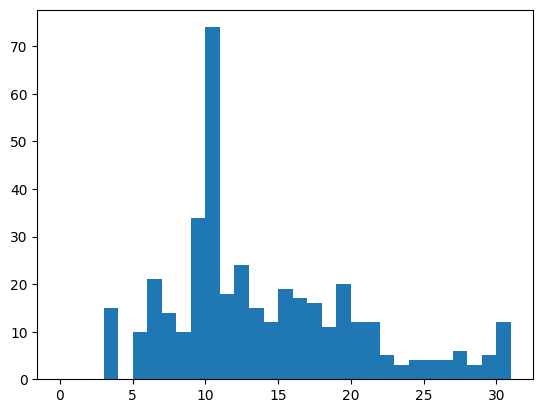

In [8]:
counts, bins, _ = plt.hist(maxes, bins=np.arange(32))

178.0 266.0 342.0 400.0


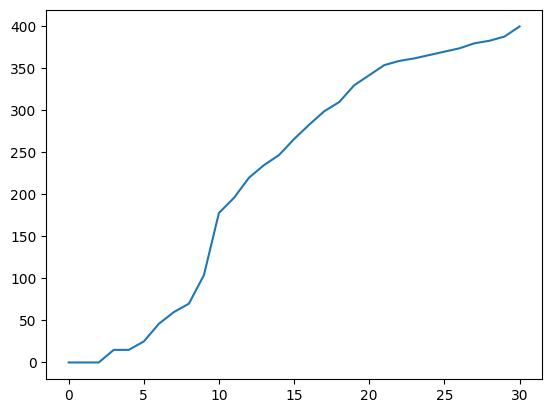

In [9]:
cumsum = np.cumsum(counts)

plt.plot(cumsum)
print(cumsum[10], cumsum[15], cumsum[20], cumsum[30])

In [10]:
def get_batch(batch_size=batch_size):
    n = np.random.choice(np.arange(2, 6), p=[train_set[i].shape[0]/total_examples for i in range(2, 6)])

    examples = torch.randint(len(train_set[n]), size=(batch_size,))

    train_batch = train_set[n][examples]
    test_batch = test_set[n][examples]

    x_train, y_train = train_batch[:, :, 0], train_batch[:, :, 1]
    x_test, y_test = test_batch[:, 0, 0], test_batch[:, 0, 1]

    return x_train, y_train, x_test, y_test

In [94]:
def run_batch(x_train, y_train, x_test, y_test):

    graph.init_vals(batch_size=batch_size)
    graph.learn(x_train, y_train, dt=dt, time=T, apply_once=True, reset_nodes=True)

    graph.reset_vals(nodes=True, edges=False)
    y_pred = graph.forward(x_test, dt=dt, time=T, apply_once=True)
    
    # I want to separately weigh padding and places where input != output

    # Where padding is
    padding = torch.where(y_test.argmax(-1) == 10, 1, 0).unsqueeze(-1).expand(-1, -1, 11).float() # Add extra pixel class dim

    # Where differences are (excluding padding)
    diff = (1-padding) * torch.where(x_test.argmax(-1) != y_test.argmax(-1), 1, 0).unsqueeze(-1).expand(-1, -1, 11).float() # Add extra pixel class dim

    # Same is where not padding and not different
    same = (1-padding) * (1-diff)

    # Where it was padding
    if padding.mean(-1).sum() > 0:# Prevent nans
        pad_loss = torch.square(y_pred * padding - y_test * padding).sum() / padding.mean(-1).sum() # Get rid of extra dim before counting
    else:
        pad_loss = 0
    
    # Where output was same as input
    if same.mean(-1).sum() > 0:# Prevent nans
        same_loss = torch.square(y_pred * same - y_test * same).sum() / same.mean(-1).sum() # Get rid of extra dim before counting
    else:
        same_loss = 0

    # Actual thing we mostly want to optimize
    if diff.mean(-1).sum() > 0:# Prevent nans
        diff_loss = torch.square(y_pred * diff - y_test * diff).sum() / diff.mean(-1).sum() # Get rid of extra dim before counting
    else:
        diff_loss = 0

    # The reason we separated and re aggregated like this was to ensure number of pixels does not have an effect on each of these categories
    loss = diff_loss + same_loss + pad_loss

    # Diff acc
    if diff.mean(-1).sum() > 0:# Prevent nans
        acc = ((y_pred.argmax(-1) == y_test.argmax(-1)).float() * diff.mean(-1)).sum() / diff.mean(-1).sum()
    else:
        # Count same acc if literally 0 diff
        acc = ((y_pred.argmax(-1) == y_test.argmax(-1)).float() * same.mean(-1)).sum() / same.mean(-1).sum()

    return loss, acc

with torch.no_grad():
    x_train, y_train, x_test, y_test = get_batch()
    loss, acc = run_batch(x_train, y_train, x_test, y_test)

    print(loss, acc)

tensor(2.4420, device='cuda:0') tensor(0., device='cuda:0')


In [95]:
ACCUM_SIZE = 64

mean_acc = 0
step = 0

grads = []

In [96]:
while mean_acc < 1:
    t0 = time.time()
    optimizer.zero_grad()
    x_train, y_train, x_test, y_test = get_batch()

    with autocast():
        task_loss, acc = run_batch(x_train, y_train, x_test, y_test)

    overflow_loss = graph.overflow()
    loss = task_loss + overflow_loss

    scaler.scale(loss).backward()

    if all(not torch.isnan(p.grad).any() for p in graph.parameters()):
        grads.append([p.grad for p in graph.parameters()])

    if len(grads) > ACCUM_SIZE:
        grads = [torch.stack([grads[j][i] for j in range(len(grads))], axis=0).mean(0) for i in range(len(grads[0]))]
        for p, grad in zip(graph.parameters(), grads):
            p.grad = grad

        torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
        # optimizer.step()
        scaler.step(optimizer)  # Scale the optimizer step
        scaler.update()
        
        grads = []


    entry = {"loss":task_loss.item(), "acc":acc.item(), "overflow":overflow_loss.item()}
    log.append(entry)

    mean_acc = np.nanmean([e['acc'] for e in log[-100:]])
    step += 1
    print(f"loss:{np.nanmean([e['loss'] for e in log[-100:]]):05.3f}, acc:{mean_acc:05.3f}, overflow:{entry['overflow']:05.3f}, Time:{time.time()-t0:05.3f} step:{step}", end="\r")

KeyboardInterrupt: 

In [103]:
graph.save("chkpt.pt")

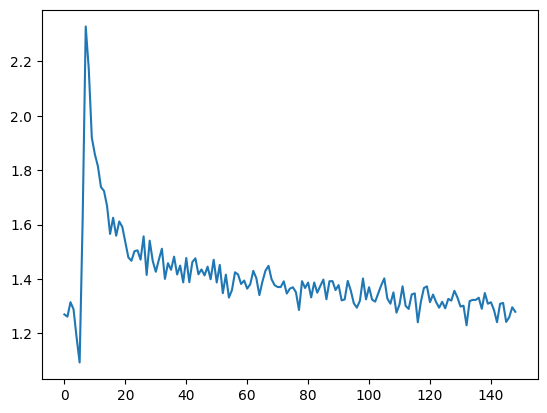

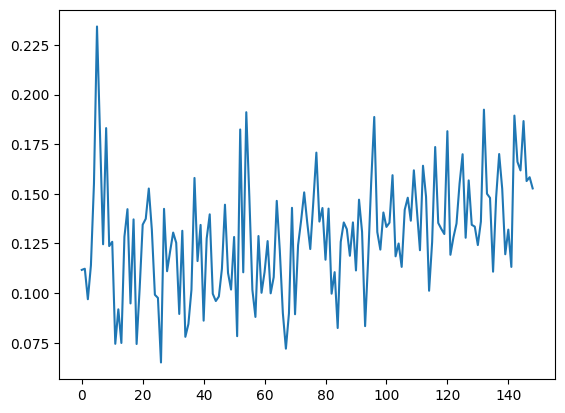

In [97]:
window = 100
losses = [e['loss'] for e in log]
accs = [e['acc'] for e in log]
plt.plot([np.nanmean(losses[i:i+window]) for i in range(0, len(losses)-window, window)])
plt.show()

plt.plot([np.nanmean(accs[i:i+window]) for i in range(0, len(accs)-window, window)])
plt.show()

In [99]:
with torch.no_grad():
    x_train, y_train, x_test, y_test = get_batch()

    graph.init_vals(batch_size=batch_size)
    graph.learn(x_train, y_train, dt=dt, time=T, apply_once=True, reset_nodes=True)

    graph.reset_vals(nodes=True, edges=False)
    y_pred = graph.forward(x_test, dt=dt, time=T, apply_once=True)

# Where padding is
padding = torch.where(y_test.argmax(-1) == 10, 1, 0).unsqueeze(-1).expand(-1, -1, 11).float() # Add extra pixel class dim

# Where differences are (excluding padding)
diff = (1-padding) * torch.where(x_test.argmax(-1) != y_test.argmax(-1), 1, 0).unsqueeze(-1).expand(-1, -1, 11).float() # Add extra pixel class dim

# Same is where not padding and not different
same = (1-padding) * (1-diff)

# Where it was padding
if padding.mean(-1).sum() > 0:# Prevent nans
    pad_loss = torch.square(y_pred * padding - y_test * padding).sum() / padding.mean(-1).sum() # Get rid of extra dim before counting
else:
    pad_loss = 0

# Where output was same as input
if same.mean(-1).sum() > 0:# Prevent nans
    same_loss = torch.square(y_pred * same - y_test * same).sum() / same.mean(-1).sum() # Get rid of extra dim before counting
else:
    same_loss = 0

# Actual thing we mostly want to optimize
if diff.mean(-1).sum() > 0:# Prevent nans
    diff_loss = torch.square(y_pred * diff - y_test * diff).sum() / diff.mean(-1).sum() # Get rid of extra dim before counting
else:
    diff_loss = 0

# Care most about when it actually has to do something
# Second most important is getting when output and input are the same
# Lastly, getting padding is the least important
loss = diff_loss + .25 * same_loss + .05 * pad_loss

# Diff acc
if diff.mean(-1).sum() > 0:# Prevent nans
    acc = ((y_pred.argmax(-1) == y_test.argmax(-1)).float() * diff.mean(-1)).sum() / diff.mean(-1).sum()
else:
    # Count same acc if literally 0 diff
    acc = ((y_pred.argmax(-1) == y_test.argmax(-1)).float() * same.mean(-1)).sum() / same.mean(-1).sum()



print(acc)

tensor(0.3913, device='cuda:0')


In [100]:
# print(x_test.reshape(20, 20, -1).argmax(-1))
print(x_test.reshape(20, 20, -1).argmax(-1)[1:19, 1:19])
print(y_test.reshape(20, 20, -1).argmax(-1)[1:19, 1:19])
print(y_pred.reshape(20, 20, -1).argmax(-1)[1:19, 1:19])

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, 10],
        [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  5,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  0,  5,  0,  0,  0,  7,  0,  0,  6,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10],
        [ 5,  0,  0,  0,  0,  4,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  8, 10],
        [ 5,  0,

torch.Size([1, 400, 11])


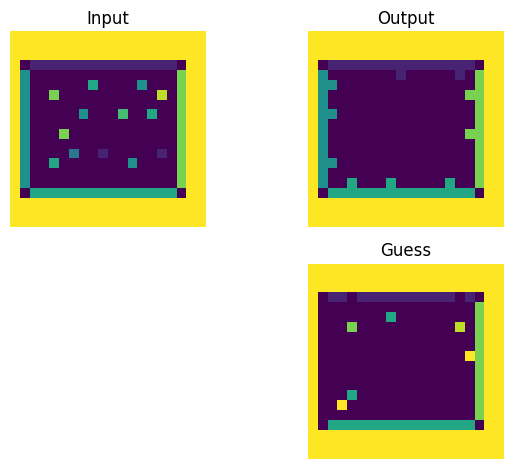

In [101]:
print(y_test.shape)

plt.subplot(2, 2, 1)
plt.axis('off')
plt.title("Input")
plt.imshow(x_test.reshape(20, 20, -1).argmax(-1).cpu())
# plt.show()

plt.subplot(2, 2, 2)
plt.axis('off')
plt.title("Output")
plt.imshow(y_test.reshape(20, 20, -1).argmax(-1).cpu())
# plt.show()

plt.subplot(2, 2, 4)
plt.axis('off')
plt.title("Guess")
plt.imshow(y_pred.reshape(20, 20, -1).argmax(-1).cpu())

plt.tight_layout()
# plt.savefig("Proof_of_concept.png")
plt.show()

In [15]:
STEPS = 1_000_000

bar = tqdm(range(STEPS))
for step in bar:

    optimizer.zero_grad()

    n = torch.randint(2, 6, size=(1,), device=device)[0]
    # x_batch_inp = torch.rand(BATCH_SIZE, n, 1, SIZE**2, 11, device=device)# , _, n = get_batch()
    x_batch = torch.nn.functional.one_hot(torch.randint(11, size=(BATCH_SIZE, n, 2, SIZE**2), device=device), 11)

    # x_batch = torch.cat([x_batch_inp, x_batch_out], axis=2)

    task_loss, acc = run_memorize_batch(x_batch, n)

    overflow_loss = graph.overflow()

    loss = task_loss + overflow_loss

    if not torch.isnan(loss) and loss < 1e2:

        loss.backward()

        torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
        optimizer.step()

        entry = {"loss":task_loss.item(), "acc":acc.item(), "overflow":overflow_loss.item(), "avg_acc":np.mean([e["acc"] for e in log[-1000:]])}
        log.append(entry)
        bar.set_postfix(entry)

  0%|          | 1/1000000 [00:00<202:16:03,  1.37it/s]C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 10731/1000000 [1:52:20<190:14:29,  1.44it/s, loss=0.0648, acc=0.36, overflow=0, avg_acc=0.44]         

: 

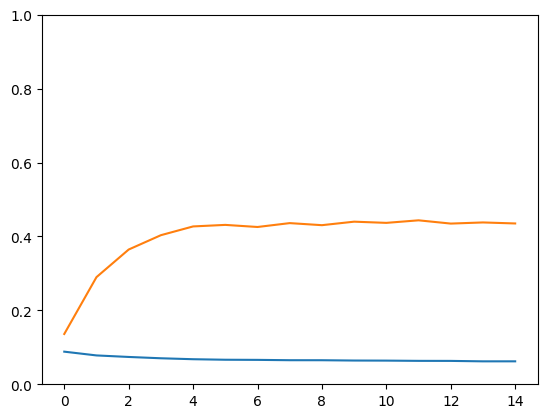

In [47]:
window = 400
plt.plot([np.mean([e['loss'] for e in log[i:i+window]]) for i in range(0, len(log), window)])
plt.ylim(0, 1)
window = 400
plt.plot([np.mean([e['acc'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

In [ ]:
STEPS = 1_000_000

log = []

bar = tqdm(range(STEPS))
for step in bar:

    optimizer.zero_grad()

    x_batch, _, n = get_batch()

    task_loss, acc = run_memorize_batch(x_batch, n)

    overflow_loss = graph.overflow()

    loss = task_loss + overflow_loss

    if not torch.isnan(loss) and loss < 1e2:

        loss.backward()

        torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
        optimizer.step()

        entry = {"loss":task_loss.item(), "acc":acc.item(), "overflow":overflow_loss.item(), "avg_acc":np.mean([e["acc"] for e in log[-1000:]])}
        log.append(entry)
        bar.set_postfix(entry)

  0%|          | 0/1000000 [00:00<?, ?it/s]

C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 647/1000000 [05:52<151:16:34,  1.84it/s, loss=0.0725, acc=0.4, overflow=0, avg_acc=0.409]          


KeyboardInterrupt: 

In [71]:
STEPS = 1_000_000

log = []


bar = tqdm(range(STEPS))
for step in bar:

    optimizer.zero_grad()

    x_batch, y_batch, n = get_batch()

    task_loss, acc = run_batch(x_batch, y_batch, n)

    overflow_loss = graph.overflow()

    loss = task_loss + overflow_loss

    if not torch.isnan(loss) and loss < 1e2:

        loss.backward()

        torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
        optimizer.step()

        entry = {"loss":task_loss.item(), "acc":acc.item(), "overflow":overflow_loss.item(), "avg_acc":np.mean([e["acc"] for e in log[-1000:]])}
        log.append(entry)
        bar.set_postfix(entry)

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 635/1000000 [06:02<158:30:36,  1.75it/s, loss=0.027, acc=0.83, overflow=0, avg_acc=0.703]         


KeyboardInterrupt: 

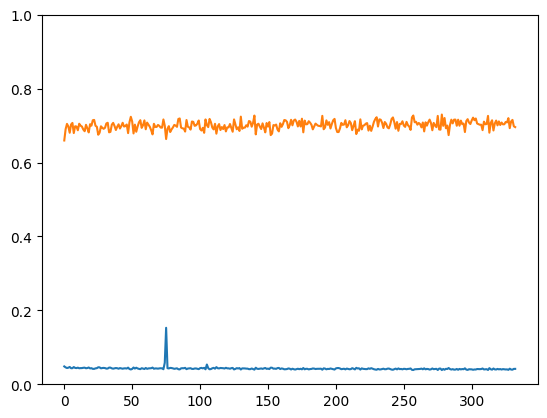

In [63]:
window = 400
plt.plot([np.mean([e['loss'] for e in log[i:i+window]]) for i in range(0, len(log), window)])
plt.ylim(0, 1)
window = 400
plt.plot([np.mean([e['acc'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

In [ ]:
print([np.mean([e['acc'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

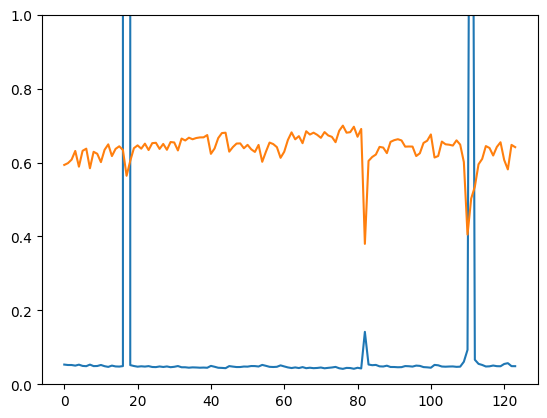

In [ ]:
window = 400
plt.plot([np.mean([e['loss'] for e in log[i:i+window]]) for i in range(0, len(log), window)])
plt.ylim(0, 1)
window = 400
plt.plot([np.mean([e['acc'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

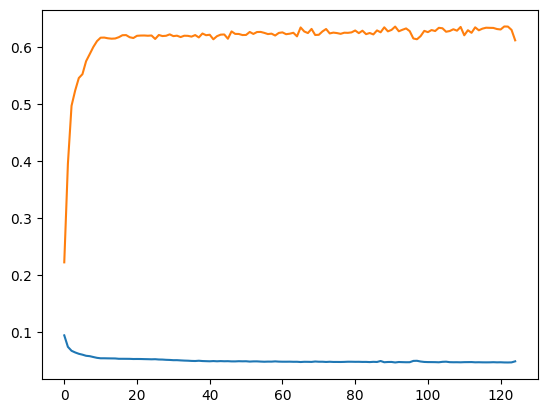

In [ ]:
window = 400
plt.plot([np.mean([e['loss'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

window = 400
plt.plot([np.mean([e['acc'] for e in log[i:i+window]]) for i in range(0, len(log), window)])

In [12]:
graph.save("arc.pt")

In [14]:
print([sum(1 if e['acc'] == 1 else 0 for e in log[i:i+400]) for i in range(0, len(log), 400)])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
print(test.shape)

torch.Size([2, 2, 900, 11])


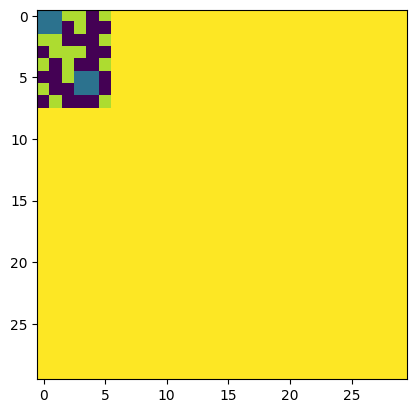

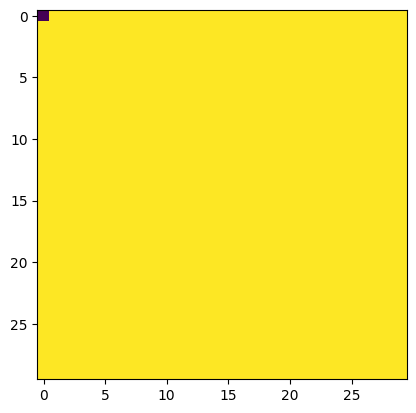

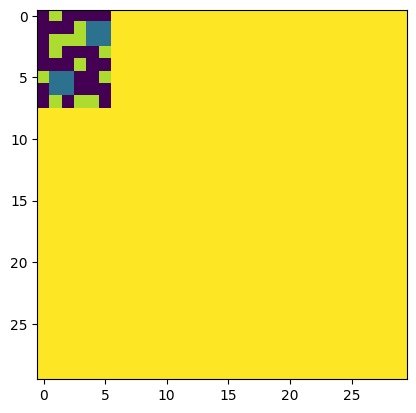

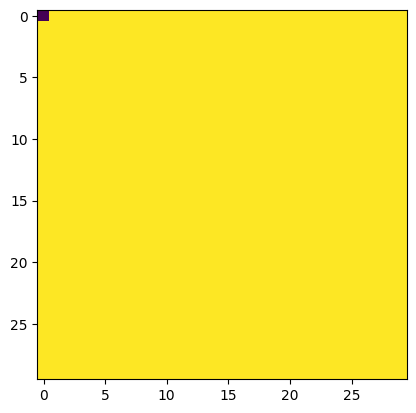

In [15]:
plt.imshow(test[0][0].argmax(-1).reshape(SIZE, SIZE).detach().cpu())
plt.show()
plt.imshow(test[0][1].argmax(-1).reshape(SIZE, SIZE).detach().cpu())
plt.show()


plt.imshow(test[1][0].argmax(-1).reshape(SIZE, SIZE).detach().cpu())
plt.show()
plt.imshow(test[1][1].argmax(-1).reshape(SIZE, SIZE).detach().cpu())
plt.show()

In [16]:
print(path)

training\239be575.json
